## IBSI Chapter 2 Phase 1 − Image filtering

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

@REF : [IBSI 2](https://www.overleaf.com/read/hwhjswzkhwdh)

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

This package is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This package is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this package.  If not, see <http://www.gnu.org/licenses/>.

**Acknowledgement**: Most of the code used for this phase was written by [Alexandre Ayotte](https://github.com/AleAyotte) and modified by the authors of this Notebook.

### Introduction

The aim of this chapter and this phase is benchmarking the filters using the phantom images is to arrive at a standard implementation. We apply filter to the phantoms to create a response maps with the same dimensions as the phantoms (64 × 64 × 64 voxels). Filters need to be applied using the settings provided in [IBSI 2 benchmarking 5.1 Table 5.1](https://www.overleaf.com/read/hwhjswzkhwdh). In this notebook we implemented 28 different settings/tests from ***1a1*** to ***7a2***.

### Dataset - Digital phantoms
The IBSI developed several 3D phantoms to test image filter implementations. All phantoms (but the orientation phantom) have the same dimension and consist of 64 × 64 × 64 isotropic voxels with 2.0 by 2.0 by 2.0 mm spacing. 8-bit voxel intensities in all phantoms fall in the range [0, 255]. The phantoms are stored in the NIfTI format. The digital phantoms can be found here: [ibsi_2_digital_phantoms](https://github.com/theibsi/data_sets/tree/master/ibsi_2_digital_phantom).

The phantoms are shown in the figure below:

<img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi2-p1-phantoms.png?raw=true" alt="Flowchart of radiomics study" style="width:500px;"/>

Every phantom has a goal to test a specific implementation. More details can be found in the [IBSI 2 section 5.1](https://www.overleaf.com/read/hwhjswzkhwdh)

In [1]:
import argparse
import math
import os
import pickle
import sys
from copy import deepcopy
from itertools import product
from json import dump, dumps
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

import numpy as np
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils
from numpyencoder import NumpyEncoder

In [2]:
from MEDimage.processing.getROI_fromIndexes import getROI_fromIndexes
from MEDimage.processing.roiExtract import roiExtract

In [3]:
def __getPathResults():
    _rp = Path(os.getcwd()) / "results/ibsi2/phase1"
    if not _rp.exists():
        Path.mkdir(_rp, parents=True)
    return _rp

### Configuration

Most important part of the code is to chose what test will be executed. The figure below shows the different tests possible: 

*1a1, 1a2, 1a3...*.

In [4]:
test_id = '1a1' # test ID. More details about tests can be found in the IBSI chapter 2 reference

<div>
    <img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi2-p1-testids1.png?raw=true" width="500"/>  
</div>

<div>
    <img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi2-p1-testids2.png?raw=true" width="500"/>  
</div>

<div>
    <img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi2-p1-testids3.png?raw=true" width="500"/>  
</div>

<div>
    <img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi2-p1-testids4.png?raw=true" width="500"/>  
</div>

Refer to the [IBSI 2 section 5.1](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970) for more details.

In [5]:
def get_input(image_name, repertory="data/Filters"):
    """
    Import the nii image and cast it into numpy nd-array.
    :param image_name: The image name without the extension.
    :param repertory: The image repertory (Options: Data. Result_Alex)
    :return: a numpy nd-array of shape (B, W, H, D) with value between 0 and 1.
    """

    example_filename = os.path.join(
        repertory, image_name + '.nii'
    )
    try:
        complete_data = nib.load(example_filename)
    except:
        complete_data = nib.load(example_filename+'.gz')

    complete_data.set_data_dtype(np.float64)

    return np.expand_dims(np.array(complete_data.dataobj), axis=0).astype(np.float32), complete_data

In [6]:
def plot_comparison(result, ground_truth_alex, _slice, test_id, filter_name):
    """
    Plot the coronal, axial and sagittal slices of the ground truth, the result and their squared error
    :param result: The result obtained by the program.
    :param ground_truth: The result obtained by Alexandre Ayotte
    :param _slice: Which slice will be plotted along each axis.
    """

    fig = plt.figure(figsize=(12, 12))
    fig.canvas.manager.set_window_title('Phase1_ID'+test_id)
    
    vmin = np.min(result)
    vmax = np.max(result)

    if (ground_truth_alex is not None):
        error = abs(ground_truth_alex - result)
        print(f'error:{np.max(error)} Alex\'s max:{np.max(ground_truth_alex)} Result\'s max:{np.max(result)}')
        mean_square_error = np.mean(error)

        fig.suptitle(f'Filter used : {filter_name}. Mean absolute error: {mean_square_error}.\
        \nResult\'s min : {vmin} Result\'s max : {vmax}', fontsize=16)

        fig.add_subplot(3, 3, 1, ylabel="Ground truth Alex")
        plt.imshow(ground_truth_alex[0, :, :, _slice], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 2)
        plt.imshow(ground_truth_alex[0, :, _slice, :], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 3)
        plt.imshow(ground_truth_alex[0, _slice, :, :], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 4, ylabel="Result")
        plt.imshow(result[0, :, :, _slice], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 5)
        plt.imshow(result[0, :, _slice, :], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 6)
        plt.imshow(result[0, _slice, :, :], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 7, ylabel="square error")
        plt.imshow(error[0, :, :, _slice], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 8)
        plt.imshow(error[0, :, _slice, :], vmin=vmin, vmax=vmax)

        fig.add_subplot(3, 3, 9)
        plt.imshow(error[0, _slice, :, :], vmin=vmin, vmax=vmax)

    else:
        fig.suptitle(f'Filter used : {filter_name}.\nResult\'s min : {vmin} Result\'s max : {vmax}',
                    fontsize=16)

        fig.add_subplot(1, 3, 1, ylabel="Result")
        plt.imshow(result[0, :, :, _slice])

        fig.add_subplot(1, 3, 2)
        plt.imshow(result[0, :, _slice, :])

        fig.add_subplot(1, 3, 3)
        plt.imshow(result[0, _slice, :, :])
    
    # color settings
    norm = Normalize(vmin=vmin, vmax=vmax)
    colorbar = ScalarMappable(norm=norm)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(colorbar, cax=cbar_ax)

    plt.show()

### Initialization

As mentioned in the dataset section, all phantoms have the same voxel spacing of 2 so it's gonna be our voxel length and will be used to compute the kernel size for some filter.

In [7]:
VOLEX_LENGTH = 2

### Image processing

The only processing done in this phase is image filtering.

#### Image filtering

The filtering is done in three steps :
- Get the digital phantom from the dataset folder using the digital phantom name (Ex: checkerboard, response...) and convert the data type to float64 (or at least float32)
- Create an instance of the filter class
- Run the convolution using the instance.

The parameters are already defined for each test (check figures above) and if the *test_id* does not match any of the cases below an error will be raised.

Check cells above to set the *test_id* and to view all the test IDs and their configuration.

In [8]:
from MEDimage.MEDimageFilter import Mean
from MEDimage.MEDimageFilter import LaplacianOfGaussian
from MEDimage.MEDimageFilter import Laws
from MEDimage.MEDimageFilter import Gabor
from MEDimage.MEDimageFilter import Wavelet

In [9]:
if test_id == "1a1":
    _in, complete_data = get_input("checkerboard")
    _filter = Mean(3, 15, padding="constant")
    result = _filter.convolve(_in)
    filter_name = "Mean"

elif test_id == "1a2":
    _in, complete_data = get_input("checkerboard")
    _filter = Mean(3, 15, padding="edge")
    result = _filter.convolve(_in)
    filter_name = "Mean"

elif test_id == "1a3":
    _in, complete_data = get_input("checkerboard")
    _filter = Mean(3, 15, padding="wrap")
    result = _filter.convolve(_in)
    filter_name = "Mean"

elif test_id == "1a4":
    _in, complete_data = get_input("checkerboard")
    _filter = Mean(3, 15, padding="symmetric")
    result = _filter.convolve(_in)
    filter_name = "Mean"

elif test_id == "1b1":
    _in, complete_data = get_input("response")
    _filter = Mean(2, 15, padding="constant")
    result = _filter.convolve(_in)
    filter_name = "Mean"

elif test_id == "2a":
    _in, complete_data = get_input("response")
    sigma = 3 / VOLEX_LENGTH
    length = 2 * int(4 * sigma + 0.5) + 1
    _filter = LaplacianOfGaussian(3, length, sigma=sigma, padding="constant")
    result = _filter.convolve(_in)
    filter_name = "LaplacianOfGaussian"

elif test_id == "2b":
    _in, complete_data = get_input("checkerboard")
    sigma = 5 / VOLEX_LENGTH
    length = 2 * int(4 * sigma + 0.5) + 1
    _filter = LaplacianOfGaussian(3, length, sigma=sigma, padding="symmetric")
    result = _filter.convolve(_in)
    filter_name = "LaplacianOfGaussian"

elif test_id == "2c":
    _in, complete_data = get_input("checkerboard")
    sigma = 5 / VOLEX_LENGTH
    length = 2 * int(4 * sigma + 0.5) + 1
    _filter = LaplacianOfGaussian(2, length, sigma=sigma, padding="symmetric")
    result = _filter.convolve(_in)
    filter_name = "LaplacianOfGaussian"

elif test_id == "3a1":
    _in, complete_data = get_input("response")
    _filter = Laws(["E5", "L5", "S5"], padding="constant", rot_invariance=False)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3a2":
    _in, complete_data = get_input("response")
    _filter = Laws(["E5", "L5", "S5"], padding="constant", rot_invariance=True)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3a3":
    _in, complete_data = get_input("response")
    _filter = Laws(["E5", "L5", "S5"], padding="constant", rot_invariance=True)
    _, result = _filter.convolve(_in, energy_image=True)
    filter_name = "Laws"

elif test_id == "3b1":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["E3", "W5", "R5"], padding="symmetric", rot_invariance=False)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3b2":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["E3", "W5", "R5"], padding="symmetric", rot_invariance=True)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3b3":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["E3", "W5", "R5"], padding="symmetric", rot_invariance=True)
    _, result = _filter.convolve(_in, energy_image=True)
    filter_name = "Laws"

elif test_id == "3c1":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["L5", "S5"], padding="symmetric", rot_invariance=False)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3c2":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["L5", "S5"], padding="symmetric", rot_invariance=True)
    result = _filter.convolve(_in, energy_image=False)
    filter_name = "Laws"

elif test_id == "3c3":
    _in, complete_data = get_input("checkerboard")
    _filter = Laws(["L5", "S5"], padding="symmetric", rot_invariance=True)
    _, result = _filter.convolve(_in, energy_image=True)
    filter_name = "Laws"

elif test_id == "4a1":
    _in, complete_data = get_input("response")
    sigma = 10 / VOLEX_LENGTH
    lamb = 4 / VOLEX_LENGTH
    size = 2 * int(7 * sigma + 0.5) + 1
    _filter = Gabor(size=size, sigma=sigma, lamb=lamb,
                    gamma=0.5, theta=-math.pi/3,
                    rot_invariance=False,
                    padding="constant"
                    )
    result = _filter.convolve(_in, False)
    filter_name = "Gabor"

elif test_id == "4a2":
    _in, complete_data = get_input("response")
    sigma = 10 / VOLEX_LENGTH
    lamb = 4 / VOLEX_LENGTH
    size = 2 * int(7 * sigma + 0.5) + 1
    _filter = Gabor(size=size, sigma=sigma, lamb=lamb,
                    gamma=0.5, theta=-math.pi/4,
                    rot_invariance=True,
                    padding="constant"
                    )
    result = _filter.convolve(_in, True)
    filter_name = "Gabor"

elif test_id == "4b1":
    _in, complete_data = get_input("sphere")
    sigma = 20 / VOLEX_LENGTH
    lamb = 8 / VOLEX_LENGTH
    size = 2 * int(7 * sigma + 0.5) + 1
    _filter = Gabor(size=size, sigma=sigma, lamb=lamb,
                    gamma=2.5, theta=-5*math.pi/4,
                    rot_invariance=False,
                    padding="symmetric"
                    )
    result = _filter.convolve(_in, False)
    filter_name = "Gabor"

elif test_id == "4b2":
    _in, complete_data = get_input("sphere")
    sigma = 20 / VOLEX_LENGTH
    lamb = 8 / VOLEX_LENGTH
    size = 2 * int(7 * sigma + 0.5) + 1
    _filter = Gabor(size=size, sigma=sigma, lamb=lamb,
                    gamma=2.5, theta=-math.pi/8,
                    rot_invariance=True,
                    padding="symmetric"
                    )
    result = _filter.convolve(_in, True)
    filter_name = "Gabor"

elif test_id == "5a1":
    _in, complete_data = get_input("response")
    _filter = Wavelet(ndims=3, wavelet_name="db2",
                      rot_invariance=False,
                      padding="constant"
                      )
    result = _filter.convolve(_in, _filter="LHL", level=1)
    filter_name = "Wavelet_LHL_db2"

elif test_id == "5a2":
    _in, complete_data = get_input("response")
    _filter = Wavelet(ndims=3, wavelet_name="db2",
                      rot_invariance=True,
                      padding="constant"
                      )
    result = _filter.convolve(_in, _filter="LHL", level=1)
    filter_name = "Wavelet_LHL_db2"

elif test_id == "6a1":
    _in, complete_data = get_input("sphere")
    _filter = Wavelet(ndims=3, wavelet_name="coif1",
                      rot_invariance=False,
                      padding="wrap"
                      )
    result = _filter.convolve(_in, _filter="HHL", level=1)
    filter_name = "Wavelet_HHL_coif1"

elif test_id == "6a2":
    _in, complete_data = get_input("sphere")
    _filter = Wavelet(ndims=3, wavelet_name="coif1",
                      rot_invariance=True,
                      padding="wrap"
                      )
    result = _filter.convolve(_in, _filter="HHL", level=1)
    filter_name = "Wavelet_coif1"

elif test_id == "7a1":
    _in, complete_data = get_input("checkerboard")
    _filter = Wavelet(ndims=3, wavelet_name="haar",
                      rot_invariance=True,
                      padding="symmetric"
                      )
    result = _filter.convolve(_in, _filter="LLL", level=2)
    filter_name = "Wavelet_LLL_haar"

elif test_id == "7a2":
    _in, complete_data = get_input("checkerboard")
    _filter = Wavelet(ndims=3, wavelet_name="haar",
                      rot_invariance=True,
                      padding="symmetric"
                      )
    result = _filter.convolve(_in, _filter="HHH", level=2)
    filter_name = "Wavelet_HHH_haar"
else:
    raise NotImplementedError


We will upload benchmarks for comparison

In [10]:
try:
    ground_truth_alex, _ = get_input(test_id, "data/Filters/Result_Alex")

except Exception as e:
    print(f"Problem loading Alex's ground truth file, error : {e}")
    ground_truth_alex = None

Finally we print the results max and min for comparison and we plot the final results with the ground truth (if there is one).

error:1.4080715061481897e-05 Alex's max:127.53778076171875 Result's max:127.53778016178174


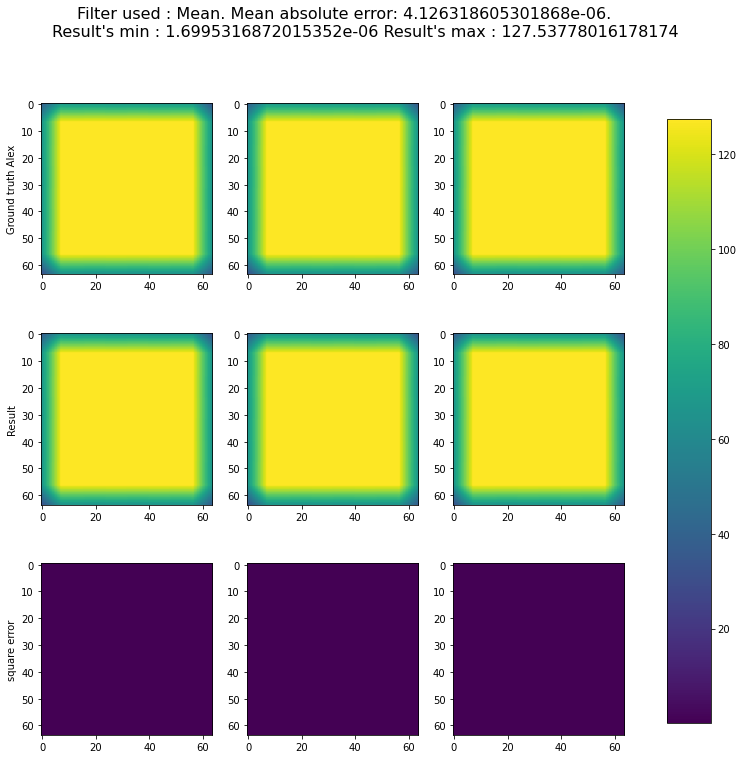

In [11]:
plot_comparison(result, 
                ground_truth_alex, 
                _slice=31, 
                test_id=test_id, 
                filter_name=filter_name)

Run the next cell to save the final result (filtered imaging data) locally.

In [12]:
#img = nib.Nifti1Image(np.squeeze(result), affine=complete_data.affine, header=complete_data.header)
#img.to_filename(__getPathResults() / args.test_id + '.nii.gz')  # Save as NiBabel file